## Import dependencies

In [1]:
## Get dependencies ##

import numpy as np
import string
import math
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
sys.path.append('..')
from GIR import *
import scipy as sp
import pickle
import time
import scipy as sp
from scipy import signal
from scipy.io.idl import readsav
import os
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import glob
import requests
import ftplib
import io
import cmocean
from bs4 import BeautifulSoup
import urllib.request
from io import StringIO, BytesIO
from zipfile import ZipFile
import tqdm
import seaborn as sn

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}
    
## Matplotlib rcparams setup:

matplotlib.rcParams['font.family']='Helvetica'
matplotlib.rcParams['font.size']=11
# matplotlib.rcParams['font.weight']=400

matplotlib.rcParams['image.cmap']='cmo.ice'

matplotlib.rcParams['axes.prop_cycle']=matplotlib.cycler('color',['011936','FF7D00','225560','BFACAA','D72638','788C9B','A33F00','7CAAB0','685655','EB767C'])
matplotlib.rcParams['axes.formatter.limits']=-3,3
matplotlib.rcParams['axes.labelweight']=300

matplotlib.rcParams['legend.frameon']=False

matplotlib.rcParams['boxplot.whiskers']=(5,95)
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.medianprops.color']='black'

matplotlib.rcParams['errorbar.capsize']=5

matplotlib.rcParams['hist.bins']='auto'

plt.rcParams['pdf.fonttype'] = 42

%matplotlib inline

%load_ext line_profiler
%load_ext memory_profiler

## Contents:
- SSP inverse emissions (CO2 CH4 N2O)
- SSP concentrations (CO2 CH4 N2O)
- SSP forcings
- SSP temperature plumes
- Comparison of C4MIP / FaIR carbon cycle feedback parameters?

### Supplementary figures
- comparison of the FaIR and GIR carbon cycle
- Etminan comparison (OLBL vs Etminan formulae)
- comparing the CH4 lifetime computation with Holmes
- 1pctCO2 / abrupt4xCO2, compare to CMIP6
- compare SSPs to CMIP6?

## NROY Ensemble Generation

#### Attributable warming

In [2]:
## Import data
baseline = ['1861','1880']

url = "https://www.metoffice.gov.uk/hadobs/hadcrut4/data/current/time_series/HadCRUT.4.6.0.0.monthly_ns_avg.txt"
req = requests.get(url, headers=header)
data = StringIO(req.text)
HadCRUT4 = pd.read_csv(data,delim_whitespace=True,index_col=0,names=['date','anom','lower_bias','upper_bias','lower_measure','upper_measure','lower_cover','upper_cover','lower_bias_measure','upper_bias_measure','lower_full','upper_full']).apply(pd.to_numeric)
HadCRUT4.index = pd.to_datetime(['-'.join(x.split('/'))+'-01' for x in HadCRUT4.index])
HadCRUT4 = HadCRUT4['anom'].rename('HadCRUT4')

GISS = pd.read_csv("https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.txt",skiprows=7,skipfooter=7,delim_whitespace=True,index_col=0).iloc[:,:12]
GISS = GISS.loc[GISS.index!='Year'].replace('****',np.nan).apply(pd.to_numeric)/100
month_map = dict(zip(GISS.columns,["{:02d}".format(x) for x in np.arange(1,13)]))
GISS = pd.DataFrame(GISS.values.flatten(),index = pd.to_datetime([x+'-'+month_map[y]+'-01' for x in GISS.index for y in GISS.columns]),columns=['anom'])
GISS = GISS['anom'].rename('GISTEMP')

CW_Had4_krig = pd.read_csv("https://www-users.york.ac.uk/~kdc3/papers/coverage2013/had4_krig_v2_0_0.txt",delim_whitespace=True,index_col=0,names=['date','anom','unc_full','unc_cover','unc_ens']).apply(pd.to_numeric)
CW_Had4_krig.index = pd.to_datetime([str(int(x//1))+'-'+"{:02d}".format(int((x % 1)*12)+1)+'-01' for x in CW_Had4_krig.index])
CW_Had4_krig = CW_Had4_krig['anom'].rename('CW')

Berkeley = pd.read_csv("http://berkeleyearth.lbl.gov/auto/Global/Land_and_Ocean_complete.txt",skiprows=76,delim_whitespace=True,usecols=[0,1,2,3],names=['date','month','anom','unc_full'])
Berkeley = Berkeley.iloc[:Berkeley.loc[Berkeley.date=='%'].index.min()].apply(pd.to_numeric)
Berkeley.index = pd.to_datetime(Berkeley.date.astype(str) + Berkeley.month.astype(str),format='%Y%m')
Berkeley = Berkeley['anom'].rename('Berkeley')

parser = 'html.parser'  # or 'lxml' (preferred) or 'html5lib', if installed
resp = urllib.request.urlopen("https://www.ncei.noaa.gov/data/noaa-global-surface-temperature/v5/access/timeseries/")
soup = BeautifulSoup(resp, parser, from_encoding=resp.info().get_param('charset'))
NOAA_fname = [x['href'] for x in soup.find_all('a', href=True) if x['href'].split('.')[1:5]==['mon','land_ocean','90S','90N']][0]
NOAA = pd.read_csv("https://www.ncei.noaa.gov/data/noaa-global-surface-temperature/v5/access/timeseries/"+NOAA_fname,delim_whitespace=True,names=['date','month','anom','unc_full'],usecols=[0,1,2,3]).apply(pd.to_numeric)
NOAA.index = pd.to_datetime(NOAA.date.astype(str) + NOAA.month.astype(str),format='%Y%m')
NOAA = NOAA['anom'].rename('NOAA')

## Combine into a single df

GMST_datasets = pd.concat([HadCRUT4,CW_Had4_krig,GISS,NOAA,Berkeley],axis=1)

## Baseline to 1861:1880 OR to HadCRUT4 20C mean if data begins in 1880 (GISTEMP / NOAA)

GMST_datasets.loc[:,['HadCRUT4','CW','Berkeley']] -= GMST_datasets.loc[baseline[0]:baseline[1],['HadCRUT4','CW','Berkeley']].mean()
GMST_datasets.loc[:,['GISTEMP','NOAA']] -= GMST_datasets.loc['1900':'2000',['GISTEMP','NOAA']].mean() -  GMST_datasets.loc['1900':'2000','HadCRUT4'].mean()

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  # This is added back by InteractiveShellApp.init_path()


<AxesSubplot:>

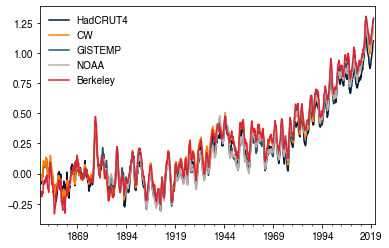

In [3]:
GMST_datasets.rolling(12).mean().plot()

In [4]:
## Import the observational uncertainty from HadCRUT

HadCRUT_ensmem_zip = ZipFile(BytesIO(requests.get('https://www.metoffice.gov.uk/hadobs/hadcrut4/data/current/time_series/HadCRUT.4.6.0.0.annual_ns_avg_realisations.zip').content))
HadCRUT_ensmem_fnames = [x.filename for x in HadCRUT_ensmem_zip.infolist() if x.filename[-4:] == '.txt']
HadCRUT_ensmem_index = pd.read_csv(HadCRUT_ensmem_zip.open(HadCRUT_ensmem_fnames[0]),header=None,delim_whitespace=True,usecols=[0],index_col=0).index
# HadCRUT_ensmem_index = pd.to_datetime(['-'.join(x.split('/'))+'-01' for x in HadCRUT_ensmem_index])
HadCRUT_ensmem = pd.concat([pd.read_csv(HadCRUT_ensmem_zip.open(x),header=None,delim_whitespace=True,usecols=[1]).iloc[:,0].rename(str(i)) for i,x in enumerate(HadCRUT_ensmem_fnames)],axis=1)
HadCRUT_ensmem.index = HadCRUT_ensmem_index

In [5]:
## import forcing ensemble: for now, use the most up-to-date copy I have (.idlsave)

forcing_dataset = readsav('/home/leachl/Documents/Datasets/RF/1750_Oct2017_forcings.idlsave')
rf_ant = pd.DataFrame(forcing_dataset['rf_anthro'].byteswap().newbyteorder(),index = pd.to_datetime([str(int(x))+'-01-01' for x in forcing_dataset['year']])).apply(pd.to_numeric)
rf_nat = pd.DataFrame(forcing_dataset['rf_nat'].byteswap().newbyteorder(),index = pd.to_datetime([str(int(x))+'-01-01' for x in forcing_dataset['year']])).apply(pd.to_numeric)

In [220]:
## creating a forcing response dataset

erf_ar6 = pd.read_csv('https://raw.githubusercontent.com/Priestley-Centre/ssp_erf/master/SSPs/ERF_ssp245_1750-2500.csv',index_col=0,dtype=float)

aer_ar6 = pd.read_csv('../tmp/aerosol_forcing.csv',index_col=0)

In [234]:
aer_ar6.loc[2019]

pc05   -1.490994
pc16   -1.249130
mean   -0.901706
pc50   -0.886513
pc84   -0.553430
pc95   -0.351705
Name: 2019, dtype: float64

In [7]:
## create the response parameter ranges:

### based on inferred ranges from CMIP6
response_names = ['response_'+str(x) for x in np.arange(27)]
response_params = pd.DataFrame(index=['d','q'],columns = pd.MultiIndex.from_product([response_names,[1,2,3]])).apply(pd.to_numeric)
response_params.loc[:] = 0

d1_range = [0.22,0.92,2.0]
d2_range = [4.5,7.2,15]
d3_range = [130,291,683]
q1_range = [0.077,0.2,0.35]

TCR_range = [0.875, 1.86, 2.66]
RWF_range = [0.35 , 0.55, 0.75]

i=0
for d_num in np.arange(3):
    for TCR in TCR_range:
        for RWF in RWF_range:
            response_params.loc['d',(response_names[i],1)] = d1_range[d_num]
            response_params.loc['d',(response_names[i],2)] = d2_range[d_num]
            response_params.loc['d',(response_names[i],3)] = d3_range[d_num]
            response_params.loc['q',(response_names[i],1)] = q1_range[d_num]
            
            q2,q3 = sp.optimize.root(lambda x: q_to_tcr_ecs(response_params.reindex([response_names[i]],axis=1,level=0) + [[0,0],[0,x[0]],[0,x[1]]],F_2x=3.76).values.flatten() - np.array([TCR/RWF,TCR]),x0=np.array([0.32,0.47]),method='lm').x
            
            response_params.loc['q',(response_names[i],2)] = q2
            response_params.loc['q',(response_names[i],3)] = q3
            
            i+=1
            
## remove any that are unphysical (negative parameters)

response_params = response_params.reindex([i for i,x in ((response_params<0).sum().unstack().sum(axis=1)==1).iteritems() if not x],axis=1,level=0)

In [8]:
## generate the temperature responses:

### reshape the rf dataframes into model inputs:
rf_ant['YEAR'] = [x.year for x in rf_ant.index]
rf_ant.set_index('YEAR',inplace=True)
rf_ant.columns = pd.MultiIndex.from_product([['forcing_'+str(x) for x in rf_ant.columns],['forcing']])
rf_ant = rf_ant.reindex(rf_ant.index.append(pd.Index([2018,2019])))
rf_ant.loc[2018] = rf_ant.loc[2017]+(rf_ant.loc[2017] - rf_ant.loc[2012])/5
rf_ant.loc[2019] = rf_ant.loc[2017]+2*(rf_ant.loc[2017] - rf_ant.loc[2012])/5

rf_nat['YEAR'] = [x.year for x in rf_nat.index]
rf_nat.set_index('YEAR',inplace=True)
rf_nat.columns = pd.MultiIndex.from_product([['forcing_'+str(x) for x in rf_nat.columns],['forcing']])
rf_nat.loc[2018] = rf_nat.loc[2017]+(rf_nat.loc[2017] - rf_nat.loc[2012])/5
rf_nat.loc[2019] = rf_nat.loc[2017]+2*(rf_nat.loc[2017] - rf_nat.loc[2012])/5

##
temp_ant = run_GIR(emissions_in=return_empty_emissions(rf_ant),forcing_in=rf_ant,thermal_parameters=response_params)['T'].droplevel(1,axis=1)
temp_nat = run_GIR(emissions_in=return_empty_emissions(rf_nat),forcing_in=rf_nat,thermal_parameters=response_params)['T'].droplevel(1,axis=1)

Integrating 1000 scenarios, 1 gas cycle parameter sets, 23 independent thermal response parameter sets, over ['CH4', 'CO2', 'N2O'], between 1750 and 2019...
Integrating 1000 scenarios, 1 gas cycle parameter sets, 23 independent thermal response parameter sets, over ['CH4', 'CO2', 'N2O'], between 1750 and 2019...


In [9]:
## generate the temperature dataset:

temp_obs_med = GMST_datasets.mean(axis=1).loc[:'2019'].resample('Y').mean().values

temp_obs_unc = HadCRUT_ensmem.loc[:2019].values - HadCRUT_ensmem.loc[:2019].median(axis=1)[:,np.newaxis]

temp_obs_full = temp_obs_med[:,np.newaxis] + temp_obs_unc

In [10]:
# definition to compute the regressions:
def OLSE_NORM(X,Y,add_intercept=True):
    
    ## computes a multiple OLS regression over a field against several indices. First dimension is time, second is features (X), or targets (Y)
    
    if add_intercept:
    
        X_1 = np.concatenate((np.ones(X.shape[0])[:,np.newaxis],X),axis=1)
        
    else:
        
        X_1 = X.copy()
    
    B = np.dot( np.linalg.inv( np.dot( X_1.T , X_1 ) ) , np.dot( X_1.T , Y ) )
    
    e = Y - np.dot(X_1,B)
    
    SSE = np.sum(e**2,axis=0)

    MSE_var = SSE / (X_1.shape[0] - X_1.shape[-1])

    SE_B = np.sqrt( np.diag( np.linalg.inv( np.dot( X_1.T , X_1 ) ) )[:,np.newaxis] * MSE_var[np.newaxis,:] )
    
    return {'coefs':B[1:],'coef_err':SE_B[1:],'res':e,'intercept':B[0],'intercept_err':SE_B[0]}

In [11]:
ant_coefs = pd.DataFrame(index=np.arange(100),columns=temp_ant.columns)
nat_coefs = pd.DataFrame(index=np.arange(100),columns=temp_nat.columns)

for i in tqdm.tqdm(np.arange(ant_coefs.shape[1])):
    _lreg_coefs = OLSE_NORM(np.array([temp_ant.iloc[100:,i].values,temp_nat.iloc[100:,i].values]).T,temp_obs_full)['coefs']
    ant_coefs.iloc[:,i] = _lreg_coefs[0]
    nat_coefs.iloc[:,i] = _lreg_coefs[1]

100%|██████████| 23000/23000 [06:55<00:00, 55.36it/s]


In [12]:
## computing the present day value:
temp_attr_ant = pd.DataFrame(ant_coefs.values * (temp_ant.loc[2019]-temp_ant.loc[baseline[0]:baseline[1]].mean()).values[np.newaxis,:],index=np.arange(100),columns=temp_ant.columns).unstack()
temp_attr_nat = pd.DataFrame(nat_coefs.values * (temp_nat.loc[2019]-temp_nat.loc[baseline[0]:baseline[1]].mean()).values[np.newaxis,:],index=np.arange(100),columns=temp_ant.columns).unstack()

In [13]:
## computing the present day (2015-2019) rate:
temp_rate_attr_ant = pd.DataFrame(ant_coefs.values * OLSE_NORM(np.arange(5)[:,np.newaxis],temp_ant.loc[np.arange(2015,2020)].values)['coefs'],index=np.arange(100),columns=temp_ant.columns).unstack()
temp_rate_attr_nat = pd.DataFrame(nat_coefs.values * OLSE_NORM(np.arange(5)[:,np.newaxis],temp_nat.loc[np.arange(2015,2020)].values)['coefs'],index=np.arange(100),columns=temp_ant.columns).unstack()

In [14]:
# print('Anthro Temp statistics')
# print(temp_attr_ant.describe(percentiles=[.05,.16,.33,.5,.66,.84,.95]).T)

# print('\nAnthro Temp rate statistics')
# print(temp_rate_attr_ant.describe(percentiles=[.05,.16,.33,.5,.66,.84,.95]).T)

# print('\nTotal Temp statistics')
# print((temp_attr_ant+temp_attr_nat).describe(percentiles=[.05,.16,.33,.5,.66,.84,.95]).T)

# print('\nTotal Temp rate statistics')
# print((temp_rate_attr_ant+temp_rate_attr_nat).describe(percentiles=[.05,.16,.33,.5,.66,.84,.95]).T)

print('Temp level constraint:')
print((temp_attr_ant+temp_attr_nat).quantile([0.05,0.95]).values)

print('\nTemp rate constraint:')
print((temp_rate_attr_ant+temp_rate_attr_nat).quantile([0.05,0.95]).values)

Temp level constraint:
[1.03924283 1.32285385]

Temp rate constraint:
[0.01737013 0.04642522]


In [15]:
## create parameter ensemble

### do we go for sampling gaussian forcings / non-gaussian forcings / carbon-cycle parameters / response parameters independently
### and assuming all uncertainties within these categories are correlated?

default_params = pd.read_csv('../Parameter_Sets/Complete_gas_cycle_params.csv',skiprows=1,index_col=0)
forcing_namelist = list(default_params.columns)

### forcing uncertainties (5-95):

# CO2: 20%, normal

# CH4: 28%, normal

# N2O: 20%, normal

# other GHGs: 20%, normal

# trop O3: 50%, normal

# strat O3: 200%, normal

# strat CH4: 72%, normal

# BC on snow: lognormal (see code below)

# ari: 100%

# aci: 55%

# land use change: 75%, normal

# volcanic: 50%, normal

# solar, 100%, normal

###

In [16]:
print(forcing_namelist)

['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|strat_o3', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'so2|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'halon2402|strat_o3', 'hcfc141b|strat_o3', 'hcfc142b|strat_o3', 'hcfc22|strat_o3', 'methyl_bromide|strat_o3', 'methyl_chloride|stra

In [17]:
param_categories = pd.Series(index = forcing_namelist,dtype=object)
param_categories.loc[['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8','carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methyl_bromide', 'methyl_chloride', 'nf3', 'sf6', 'so2f2', 'halon1202']] = 'other_wmghgs'
param_categories.loc['carbon_dioxide'] = 'carbon_dioxide'
param_categories.loc['methane'] = 'methane'
param_categories.loc['nitrous_oxide'] = 'nitrous_oxide'
param_categories.loc[[x for x in forcing_namelist if '|trop_o3' in x]] = 'trop_o3'
param_categories.loc[[x for x in forcing_namelist if '|strat_o3' in x]] = 'strat_o3'
param_categories.loc[[x for x in forcing_namelist if '|strat_h2o' in x]] = 'strat_h2o'
param_categories.loc[['so2', 'nox', 'co', 'nmvoc', 'bc', 'nh3', 'oc','so2|aci']] ='aerosols'
param_categories.loc['bc|bc_on_snow'] ='bc_on_snow'

In [18]:
category_distributions = pd.Series(index = param_categories.unique(),dtype=object)

category_distributions.loc['carbon_dioxide'] = sp.stats.norm(1,0.20/1.645)

category_distributions.loc['methane'] = sp.stats.norm(1,0.28/1.645)

category_distributions.loc['nitrous_oxide'] = sp.stats.norm(1,0.2/1.645)

category_distributions.loc['other_wmghgs'] = sp.stats.norm(1,0.20/1.645)

category_distributions.loc['trop_o3'] = sp.stats.norm(1,0.5/1.645)

category_distributions.loc['strat_o3'] = sp.stats.norm(1,2/1.645)

category_distributions.loc['strat_h2o'] = sp.stats.norm(1,0.72/1.645)

pct_5 = 0.04
pct_95=0.18
sigma = (np.log(0.18) - np.log(0.04)) / (sp.stats.norm().ppf(0.95)-sp.stats.norm().ppf(0.05))
mu = np.log(0.04) - sigma * sp.stats.norm().ppf(0.05)
category_distributions.loc['bc_on_snow'] = sp.stats.lognorm(s=sigma,scale=np.exp(mu))

def fit_aerosol_distribution(x,distr,pct,z):
    return np.sum(abs(distr.cdf(z,*x) - pct))
category_distributions.loc['aerosols'] = sp.stats.genlogistic(*sp.optimize.minimize(fit_aerosol_distribution,x0=np.array([0.5,1,1]),args=(sp.stats.genlogistic,np.array([0.05,0.5,0.95]),np.array([0.11,1,2.11])),method='nelder-mead').x)

In [19]:
## draw large ensembles of these distributions

N = 10000

parameter_ensemble_draw = pd.DataFrame(index = category_distributions.index , columns = ['mem'+str(x) for x in np.arange(N)])

for driver in parameter_ensemble_draw.index:
    parameter_ensemble_draw.loc[driver,:] = category_distributions.loc[driver].rvs(N)

In [20]:
# map the forcing driver categories onto the agents:
forcing_category_map = np.array([(parameter_ensemble_draw.index==param_categories.loc[x]).argmax() for x in forcing_namelist])

In [21]:
gas_parameter_ensemble = pd.concat([default_params.copy()]*N,axis=1,keys=parameter_ensemble_draw.columns)

gas_parameter_ensemble.loc['f1':'f3',:] = gas_parameter_ensemble.loc['f1':'f3',:]*parameter_ensemble_draw.values[forcing_category_map].T.reshape(1,-1)

In [22]:
## draw large ensemble of carbon cycle parameters based on the assessed range in Millar (2017):

cc_param_draw = sp.stats.norm(1,0.13/1.645).rvs(N).reshape(1,-1)

In [23]:
gas_parameter_ensemble.loc['r0':'rT',(slice(None),'carbon_dioxide')] = gas_parameter_ensemble.loc['r0':'rT',(slice(None),'carbon_dioxide')].values * cc_param_draw

In [24]:
## creating the thermal parameter response

### Key point: with three parameters it is very easy to force one to go negative: so we draw parameters from a multivariate normal inferred from the CMIP6 ensemble

## draw d1 lognormally, others normally + truncate at 3-sigma

response_par_cov = np.array([[ 2.94358445e-01,  5.58963469e-01,  1.29338443e+01,
         3.49480987e-02, -2.77113736e-02,  3.50228561e-02],
       [ 5.58963469e-01,  7.05140407e+00,  5.23675036e+01,
         1.26045312e-01,  2.19537680e-01,  2.91806222e-01],
       [ 1.29338443e+01,  5.23675036e+01,  6.34183337e+03,
         1.43715561e+00,  2.96970497e+00,  1.22502826e+01],
       [ 3.49480987e-02,  1.26045312e-01,  1.43715561e+00,
         6.51046487e-03, -4.15900581e-03,  2.58438391e-03],
       [-2.77113736e-02,  2.19537680e-01,  2.96970497e+00,
        -4.15900581e-03,  2.75795314e-02,  2.28847040e-02],
       [ 3.50228561e-02,  2.91806222e-01,  1.22502826e+01,
         2.58438391e-03,  2.28847040e-02,  7.52248663e-02]])

response_par_mean = np.array([-8.64200190e-02,  8.16552935e+00,  2.61864780e+02,  2.03596012e-01,
        3.98107002e-01,  5.45638414e-01])

response_par_ensemble = sp.stats.multivariate_normal(response_par_mean,response_par_cov).rvs(2*N)

# transform d1 back
response_par_ensemble[...,0] = np.exp(response_par_ensemble[...,0])

# We then truncate the other parameters at the 3-sigma range (this forces all parameters to be +ve)
response_par_ensemble = response_par_ensemble[np.all((response_par_ensemble[...,1:]>np.quantile(response_par_ensemble[...,1:],0.025,axis=0))&(response_par_ensemble[...,1:]<np.quantile(response_par_ensemble[...,1:],0.975,axis=0)),axis=1)]

random_indices = np.random.choice(np.arange(response_par_ensemble.shape[0]),N,replace=False)

response_par_ensemble = response_par_ensemble[random_indices]

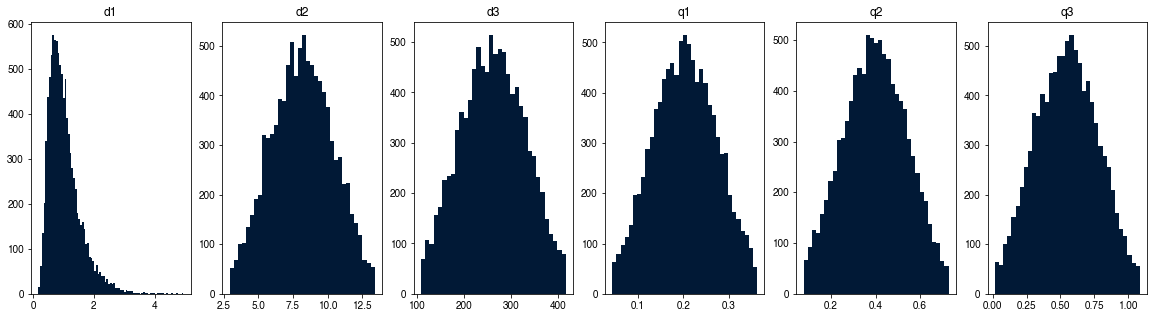

In [25]:
fig,ax = plt.subplots(1,6,figsize=(20,5))
hists = [ax[i].hist(response_par_ensemble[...,i]) for i in np.arange(6)]
titles = [ax[i].set_title(['d1','d2','d3','q1','q2','q3'][i]) for i in np.arange(6)]

In [37]:
thermal_parameter_ensemble = pd.concat([get_thermal_parameter_defaults()['default'].copy()]*N,axis=1,keys=['mem'+str(x) for x in np.arange(N)])

thermal_parameter_ensemble.loc[:] = response_par_ensemble.reshape(N,2,3).swapaxes(0,1).reshape(2,-1)

In [39]:
## get SSP emissions
from tools.RCMIP import *

In [40]:
scenarios = ['ssp'+x for x in ['119','126','245','370','370-lowNTCF-aerchemmip','370-lowNTCF-gidden','434','460','534-over','585']]
ssp_emms = pd.concat([RCMIP_to_GIR_input_emms(x) for x in scenarios],keys=['esm-'+x+'-allGHG' for x in scenarios],axis=1).interpolate()
ssp_emms -= ssp_emms.loc[1750] # emissions relative to 1750 values
ssp_forc = pd.concat([get_RCMIP_forc(x) for x in scenarios],keys=['esm-'+x+'-allGHG' for x in scenarios],axis=1).interpolate()
ssp_forc -= ssp_forc.loc[1750]

In [52]:
## let's run the ensembles!!

FULL = run_GIR(emissions_in=ssp_emms.reindex(['esm-ssp245-allGHG'],axis=1,level=0).reindex(np.arange(1750,2101)),forcing_in=ssp_forc.reindex(['esm-ssp245-allGHG'],axis=1,level=0).reindex(np.arange(1750,2101)),gas_parameters=gas_parameter_ensemble,thermal_parameters=thermal_parameter_ensemble)

# %lprun -f run_GIR run_GIR(emissions_in=ssp_emms.reindex(['esm-ssp245-allGHG'],axis=1,level=0),forcing_in=ssp_forc.reindex(['esm-ssp245-allGHG'],axis=1,level=0),gas_parameters=gas_parameter_ensemble,thermal_parameters=thermal_parameter_ensemble)

Integrating 1 scenarios, 10000 gas cycle parameter sets, 1 independent thermal response parameter sets, over ['bc', 'c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc11', 'cfc113', 'cfc114', 'cfc115', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'co', 'halon1202', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc23', 'hfc236fa', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nh3', 'nitrous_oxide', 'nmvoc', 'nox', 'oc', 'sf6', 'so2', 'so2f2'], between 1750 and 2100...


In [53]:
temp_constraint = ((FULL['T'].loc[2019]-FULL['T'].loc[baseline[0]:baseline[1]].mean())<1.32)&((FULL['T'].loc[2019]-FULL['T'].loc[baseline[0]:baseline[1]].mean())>1.04)
rate_constraint = (FULL['T'].diff(5).loc[2019]/5>0.017)&(FULL['T'].diff(5).loc[2019]/5<0.046)

(1750.0, 2020.0)

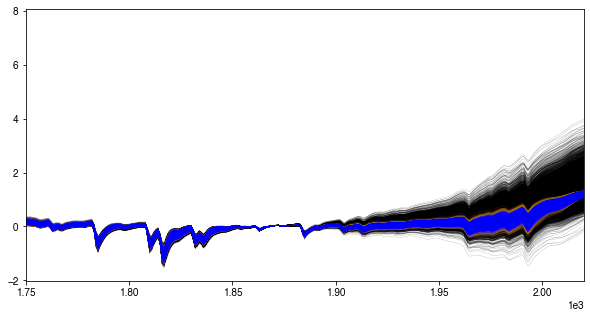

In [182]:
fig,ax = plt.subplots(figsize=(10,5))

(FULL['T']-FULL['T'].loc[1861:1880].mean()).plot(ax=ax,lw=0.1,c='k',legend=None)

(FULL['T']-FULL['T'].loc[1861:1880].mean()).loc[:,temp_constraint].plot(ax=ax,lw=0.1,c='orange',legend=None)

# (FULL['T']-FULL['T'].loc[1861:1880].mean()).loc[:,rate_constraint].plot(ax=ax,lw=0.1,c='r',legend=None)

(FULL['T']-FULL['T'].loc[1861:1880].mean()).loc[:,temp_constraint&rate_constraint].plot(ax=ax,lw=0.1,c='b',legend=None)

plt.xlim(1750,2020)

In [121]:
constrained_tcr_ecs = pd.DataFrame(index=['ECS','TCR'],columns=FULL['T'].columns.levels[1])

for mem in constrained_tcr_ecs.columns:
    f = gas_parameter_ensemble.loc['f1':'f3',(mem,'carbon_dioxide')].values
    constrained_tcr_ecs.loc[:,mem] = q_to_tcr_ecs(thermal_parameter_ensemble.reindex([mem],axis=1,level=0),F_2x=f[0]*np.log(2)+f[2]*(np.sqrt(278*2)-np.sqrt(278))).values.flatten()

In [122]:
constrained_tcr_ecs.loc['T_2100'] = (FULL['T']-FULL['T'].loc[1861:1880].mean()).loc[2100].loc['esm-ssp245-allGHG']
constrained_tcr_ecs.loc['aer_rf_2019'] = FULL['RF'].loc[2019,(slice(None),slice(None),[x for x in FULL['RF'].columns.levels[-1] if x in ['so2|aci','so2','nox','co','nmvoc','bc','nh3','oc',]])].groupby(level=[0,1]).sum().loc['esm-ssp245-allGHG']
constrained_tcr_ecs.loc['constrain'] = (rate_constraint&temp_constraint).droplevel(0)

In [206]:
print(forcing_namelist)

['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|strat_o3', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'so2|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'halon2402|strat_o3', 'hcfc141b|strat_o3', 'hcfc142b|strat_o3', 'hcfc22|strat_o3', 'methyl_bromide|strat_o3', 'methyl_chloride|stra

In [209]:
## add in some more degrees of freedom:
ghg_list = ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202','carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'halon2402|strat_o3', 'hcfc141b|strat_o3', 'hcfc142b|strat_o3', 'hcfc22|strat_o3', 'methyl_bromide|strat_o3', 'methyl_chloride|strat_o3', 'halon1202|strat_o3','methane|strat_o3', 'methane|trop_o3', 'methane|strat_h2o','co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3']
constrained_tcr_ecs.loc['ghg_rf_2019'] = FULL['RF'].loc[2019,(slice(None),slice(None),[x for x in FULL['RF'].columns.levels[-1] if x in ghg_list])].groupby(level=[0,1]).sum().loc['esm-ssp245-allGHG']
constrained_tcr_ecs.loc['co2_rf_2019'] = FULL['RF'].loc[2019,(slice(None),slice(None),'carbon_dioxide')].droplevel([0,2])

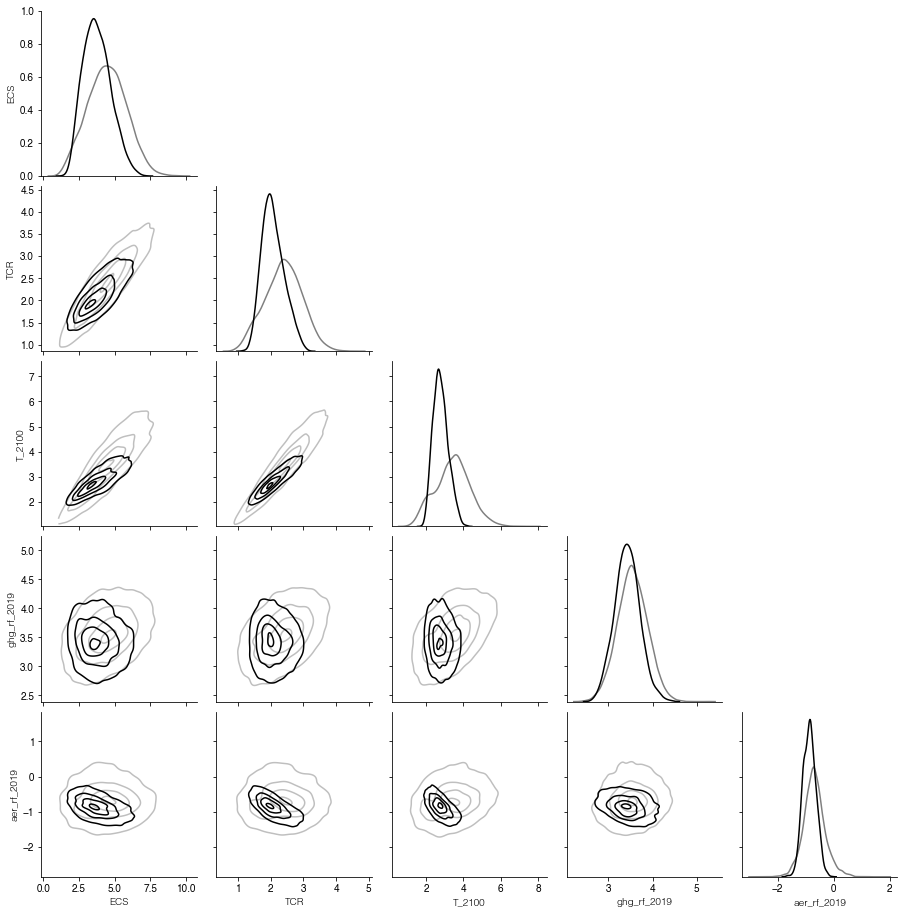

In [305]:
g = sn.PairGrid(constrained_tcr_ecs.T,vars=['ECS','TCR','T_2100','ghg_rf_2019','aer_rf_2019'],hue='constrain',diag_sharey=False,palette={1:'k',0:'grey'})

g.map_diag(sn.distplot,hist=False)

def custom_scatter(x,y,**kws):
    ax = plt.gca()
    if kws['label']==1:
        ax.scatter(x,y,c=constrained_tcr_ecs.loc['aer_rf_2019',constrained_tcr_ecs.loc['constrain'].astype(bool)],cmap=cmocean.cm.curl.reversed(),s=3,zorder=0)
    else:
        ax.scatter(x,y,c='grey',s=0.5,zorder=0)
    return ax

def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)
    
g.map_upper(hide_current_axis)

def custom_scatter_plain(x,y,**kws):
    ax = plt.gca()
    if kws['label']==1:
        ax.scatter(x,y,c='k',s=0.1,zorder=1)
    else:
        ax.scatter(x,y,c='grey',s=0.01,zorder=0)
    return ax

def custom_kde(x,y,**kws):
    ax = plt.gca()
    gridsize=200
    k = sp.stats.kde.gaussian_kde([x,y])
    xi,yi = np.mgrid[x.min():x.max():gridsize*1j,y.min():y.max():gridsize*1j]
    zi = k(np.vstack([xi.flatten(),yi.flatten()])).reshape(xi.shape)
    dens_vals = np.linspace(0,zi.max(),gridsize)
    zi_int = ((zi>=dens_vals[:,None,None])*zi).sum(axis=(1,2))/zi.sum()
    zi_int_to_dens = sp.interpolate.interp1d(zi_int,dens_vals)
    dens_contours = zi_int_to_dens([0.95,0.67,0.33,0.05])
    if kws['label']==1:
        kdeplot = ax.contour(xi,yi,zi,dens_contours,colors='k')
    else:
        ax.contour(xi,yi,zi,dens_contours,colors='grey',alpha=0.5)
#         ax.scatter(x,y,c='grey',s=0.01,zorder=0)
    return ax

g.map_lower(custom_kde)

In [211]:
constrained_tcr_ecs.loc[:,constrained_tcr_ecs.loc['constrain'].astype(bool)].T.describe(percentiles=[.05,.16,.33,.5,.66,.84,.95])

,ECS,TCR,T_2100,aer_rf_2019,constrain,cc_scaling,co2_rf_2019,ghg_rf_2019
count,2059.000000,2059.000000,2059.000000,2059.000000,2059.0,2059.000000,2059.000000,2059.000000
mean,3.773165,2.074758,2.783740,-0.867785,1.0,0.994672,1.884655,3.424421
std,0.948545,0.335841,0.397625,0.229626,0.0,0.078427,0.234481,0.283047
min,1.573618,1.191795,1.818619,-1.685275,1.0,0.727016,1.064715,2.627139
5%,2.359435,1.579753,2.188454,-1.226390,1.0,0.868937,1.512177,2.957161
16%,2.788747,1.740808,2.373462,-1.100520,1.0,0.915206,1.657143,3.145605
33%,3.283518,1.900181,2.583242,-0.973761,1.0,0.961846,1.783192,3.298405
50%,3.685214,2.035725,2.747701,-0.865224,1.0,0.995463,1.879509,3.420109
66%,4.124489,2.187115,2.926066,-0.778166,1.0,1.026721,1.972576,3.538924
84%,4.742426,2.428230,3.192313,-0.633861,1.0,1.071692,2.112568,3.696218


In [301]:
constrained_tcr_ecs.T.describe(percentiles=[.05,.16,.33,.5,.66,.84,.95])

,ECS,TCR,T_2100,aer_rf_2019,constrain,cc_scaling,co2_rf_2019,ghg_rf_2019
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.325198,2.326025,3.290215,-0.729254,0.205900,0.998594,1.954913,3.519556
std,1.307723,0.543863,0.884847,0.370138,0.404378,0.078587,0.269348,0.330437
min,1.058466,0.854435,1.013222,-2.855755,0.000000,0.669148,1.030511,2.391042
5%,2.262364,1.457993,1.924243,-1.290325,0.000000,0.871192,1.524984,2.977585
16%,2.986980,1.777184,2.395048,-1.062848,0.000000,0.919681,1.690111,3.195882
33%,3.676910,2.058900,2.843344,-0.886151,0.000000,0.964504,1.831373,3.373629
50%,4.267066,2.311079,3.236456,-0.747500,0.000000,0.999332,1.946652,3.514023
66%,4.849101,2.545903,3.625699,-0.615579,0.000000,1.031328,2.059140,3.648076
84%,5.669062,2.879898,4.174618,-0.403148,1.000000,1.075720,2.220548,3.846207


## Supplementary Figures